In [154]:
pip install sentence-transformers

Note: you may need to restart the kernel to use updated packages.


In [155]:
!pip install pygsheets gspread

In [245]:
import pygsheets
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from utils.data_set_get import load_config, load_sheet_data, upload_to_sheet
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import networkx as nx
from sentence_transformers import SentenceTransformer

# 한글 폰트 (Windows: Malgun Gothic, Mac: AppleGothic)
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

In [157]:
key_path, sheet_id = load_config(json_filename="import_data0.json")
sheet_name = '총매출 데이터(전처리 전)'

gc = pygsheets.authorize(service_account_file=key_path)
sheet = gc.open_by_key(sheet_id)
wks = sheet.worksheet_by_title(sheet_name)

df = wks.get_as_df()

KeyboardInterrupt: 

In [ ]:
# 메뉴명 매핑
menu_map = {
    '★매운가지치즈★솥밥': '매운가지치즈솥밥',
    '★우삼겹스키야키★': '우삼겹스키야키',
    '★매운가지치즈 ★ 더맵게': '매운가지치즈솥밥',
    '매운가지솥밥 더맵게': '매운가지솥밥',
    '매운가지치즈★솥밥': '매운가지치즈솥밥',
    '매운가지치즈 ★ 더맵게': '매운가지치즈솥밥',
    '매운가지치즈 ★더맵게x2': '매운가지치즈솥밥',
    '매운가지솥밥★더맵게': '매운가지솥밥',
    '★매운가지치즈★더맵게': '매운가지치즈솥밥',
    '매운가지솥밥☆더맵게x2': '매운가지솥밥',
    '★가지치즈★솥밥': '가지치즈솥밥',
    '매운가지치즈☆더맵게x2': '매운가지치즈솥밥',
    '테라 캔':'테라',
    '매운가지솥밥 더맵게x2':'매운가지솥밥',
    '★매운가지치즈 ★더맵게x2':'매운가지치즈솥밥'

}

df['상품명'] = df['상품명'].map(menu_map).fillna(df['상품명'])

In [ ]:
# 금액 수치화

def int_format(col):
    df[col] = df[col].astype(str)
    df[col] = df[col].str.replace(',', '')
    df[col] = pd.to_numeric(df[col])
    return df[col]

main_menu_list = ['가지솥밥', '꽈리고추두부솥밥', '마늘쫑솥밥', '매운가지솥밥', '매운가지치즈솥밥', '소고기숙주솥밥',
                  '스테이크솥밥', '연어솥밥', '우삼겹스키야키', '장어솥밥', '전복솥밥','가지치즈솥밥','우삼겹솥밥','고등어솥밥']

df['결제 합계'] = int_format('결제 합계')
df['매출'] = int_format('매출')
df["판매일"] = pd.to_datetime(df["판매일시"]).dt.date
df = df[df['상품명'].isin(main_menu_list)]

C:\Users\skg46\AppData\Local\Temp\ipykernel_8060\1098325737.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=menu_sales, x="수량", y="상품명", palette="viridis")


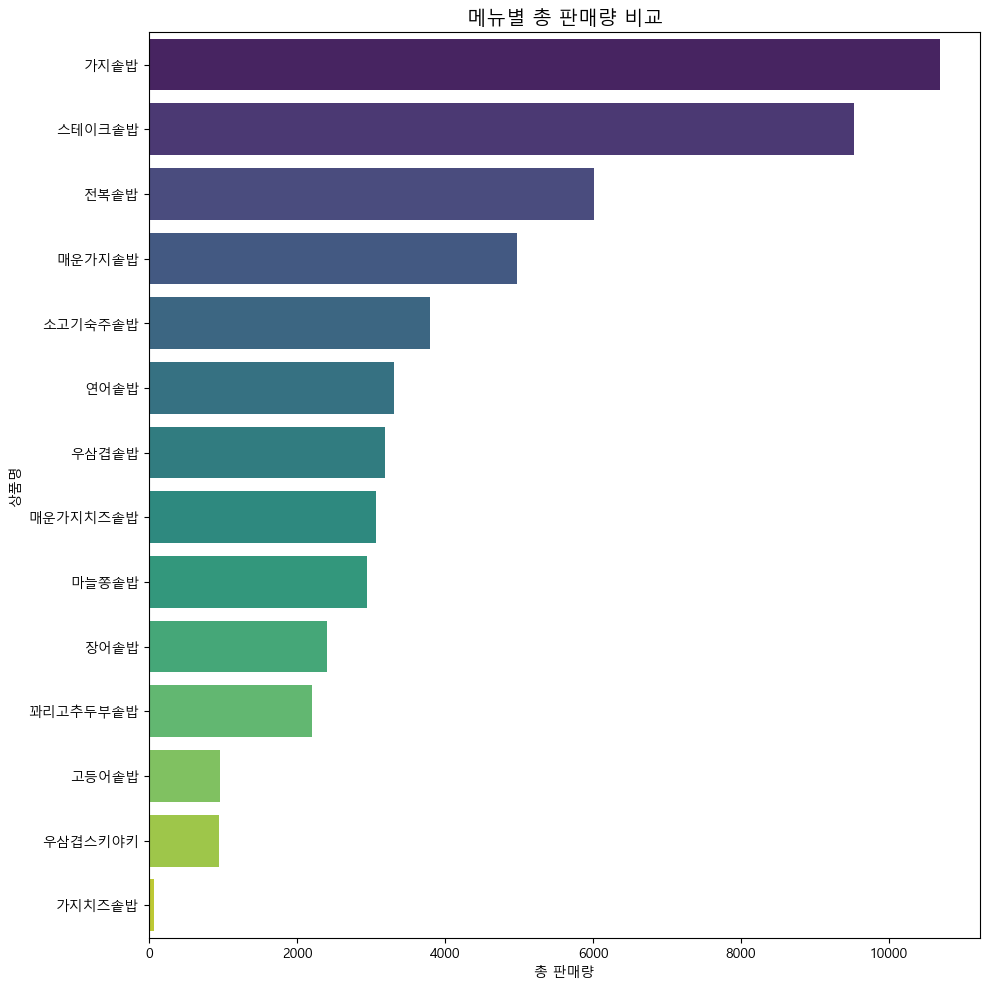

In [ ]:
# 메뉴별 총 판매량 집계
menu_sales = df.groupby("상품명")["수량"].sum().reset_index()
menu_sales = menu_sales.sort_values("수량", ascending=False)

# 시각화
plt.figure(figsize=(10,10))
sns.barplot(data=menu_sales, x="수량", y="상품명", palette="viridis")

plt.title("메뉴별 총 판매량 비교", fontsize=14)
plt.xlabel("총 판매량")
plt.ylabel("상품명")
plt.tight_layout()
plt.show()

C:\Users\skg46\AppData\Local\Temp\ipykernel_8060\3232447167.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weekday_avg.index, y=weekday_avg.values, palette="Set2")


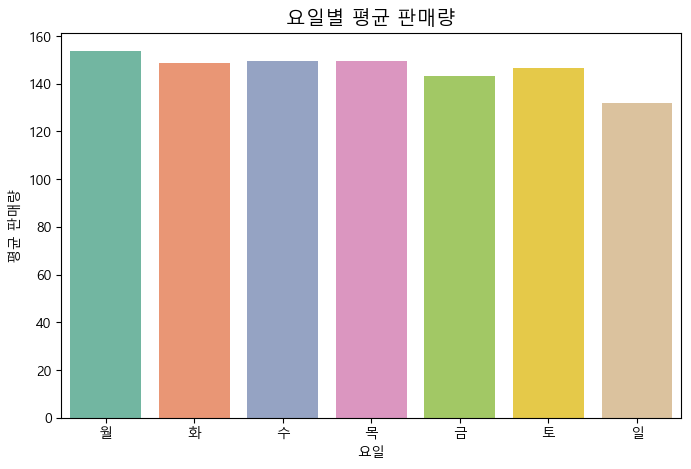

In [ ]:
# 판매일(일 단위) 추출
df["판매일"] = pd.to_datetime(df["판매일시"]).dt.date
df["요일"] = pd.to_datetime(df["판매일시"]).dt.dayofweek

# 요일 한글 매핑
weekday_map = {0:"월", 1:"화", 2:"수", 3:"목", 4:"금", 5:"토", 6:"일"}
df["요일"] = df["요일"].map(weekday_map)

# 요일별 총 판매량
weekday_total = df.groupby("요일")["수량"].sum()

# 요일별 고유 일수 (몇 주치 데이터가 있는지)
weekday_days = df.groupby("요일")["판매일"].nunique()

# 요일별 평균 판매량 = 총 판매량 ÷ 요일 등장일수
weekday_avg = (weekday_total / weekday_days).reindex(["월","화","수","목","금","토","일"])

# 시각화
plt.figure(figsize=(8,5))
sns.barplot(x=weekday_avg.index, y=weekday_avg.values, palette="Set2")
plt.title("요일별 평균 판매량", fontsize=14)
plt.xlabel("요일")
plt.ylabel("평균 판매량")
plt.show()

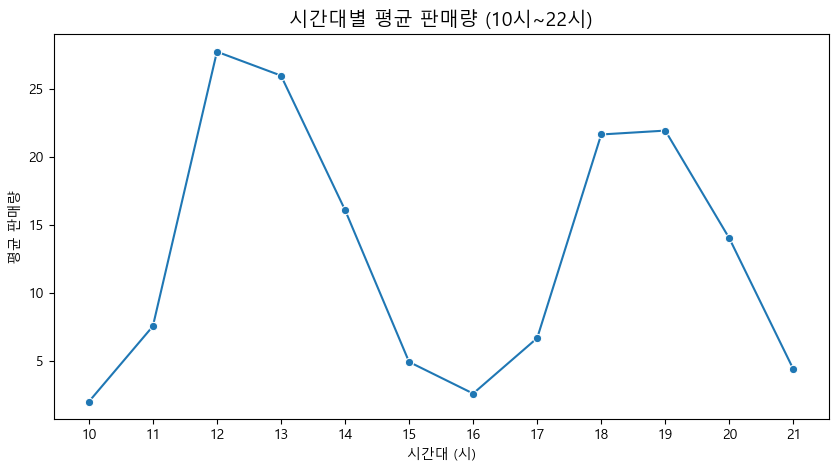

In [ ]:
# 판매일, 판매시간 추출
df["판매일"] = pd.to_datetime(df["판매일시"]).dt.date
df["판매시간"] = pd.to_datetime(df["판매일시"]).dt.hour

# 10~22시 데이터만 필터링
filtered = df[(df["판매시간"] >= 10) & (df["판매시간"] < 22)]

# 시간대별 총 판매량
hourly_total = filtered.groupby("판매시간")["수량"].sum()

# 시간대별 고유 일수 (몇 일 동안 해당 시간이 있었는지)
hourly_days = filtered.groupby("판매시간")["판매일"].nunique()

# 평균 판매량 = 총 판매량 ÷ 일수
hourly_avg = (hourly_total / hourly_days).reindex(range(10,22), fill_value=0)

# 시각화
plt.figure(figsize=(10,5))
sns.lineplot(x=hourly_avg.index, y=hourly_avg.values, marker="o")
plt.title("시간대별 평균 판매량 (10시~22시)", fontsize=14)
plt.xlabel("시간대 (시)")
plt.ylabel("평균 판매량")
plt.xticks(range(10,22))
plt.show()

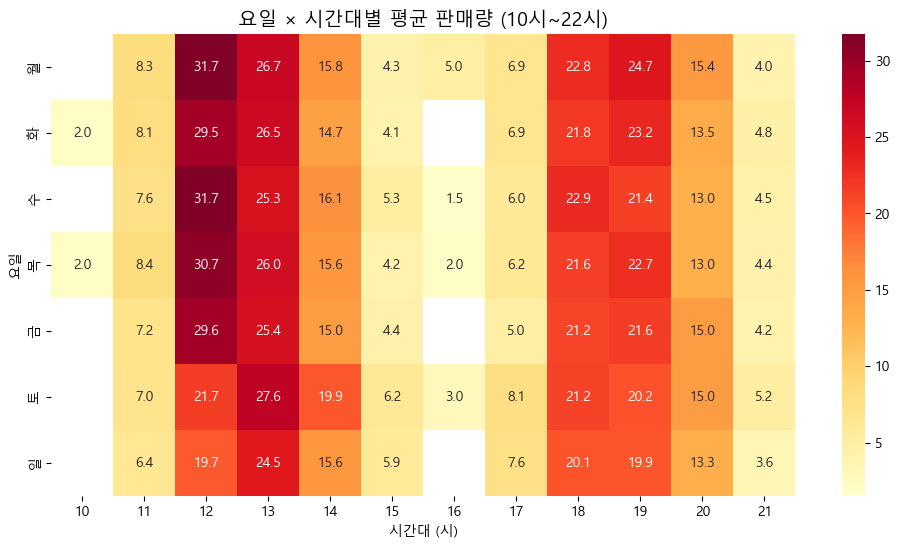

In [ ]:
# 10시~22시 데이터만 필터링
filtered = df[(df["판매시간"] >= 10) & (df["판매시간"] < 22)]

# (요일, 시간대)별 총 판매량
total_sales = filtered.groupby(["요일", "판매시간"])["수량"].sum()

# (요일, 시간대)별 등장 일수
day_counts = filtered.groupby(["요일", "판매시간"])["판매일"].nunique()

# 평균 판매량 = 총합 ÷ 일수
avg_sales = (total_sales / day_counts).unstack().reindex(["월","화","수","목","금","토","일"])

# 히트맵 시각화
plt.figure(figsize=(12,6))
sns.heatmap(avg_sales, cmap="YlOrRd", annot=True, fmt=".1f")
plt.title("요일 × 시간대별 평균 판매량 (10시~22시)", fontsize=14)
plt.xlabel("시간대 (시)")
plt.ylabel("요일")
plt.show()

C:\Users\skg46\AppData\Local\Temp\ipykernel_8060\851776288.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=count_by_group, x="구분", y="메뉴수", palette="Set2")


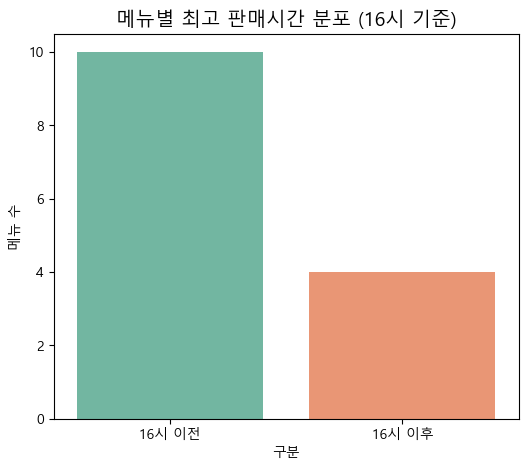

In [ ]:
# 조리가 오래 되는 메뉴와 조리가 빠르게 되는 메뉴 나누기

# 각 메뉴별 최고점 시간 구하기
peak_times = menu_hourly_avg.loc[
    menu_hourly_avg.groupby("상품명")[0].idxmax()
][["상품명", "판매시간"]]

# 16시 기준으로 분류
peak_times["구분"] = peak_times["판매시간"].apply(lambda x: "16시 이전" if x < 16 else "16시 이후")

# 그룹별 카운트
count_by_group = peak_times["구분"].value_counts().reset_index()
count_by_group.columns = ["구분", "메뉴수"]

# 시각화
plt.figure(figsize=(6,5))
sns.barplot(data=count_by_group, x="구분", y="메뉴수", palette="Set2")
plt.title("메뉴별 최고 판매시간 분포 (16시 기준)", fontsize=14)
plt.xlabel("구분")
plt.ylabel("메뉴 수")
plt.show()

In [ ]:
peak_times[peak_times['구분']=='16시 이후']

,상품명,판매시간,구분
17,가지치즈솥밥,17,16시 이후
28,고등어솥밥,18,16시 이후
116,우삼겹솥밥,19,16시 이후
126,우삼겹스키야키,19,16시 이후


C:\Users\skg46\AppData\Local\Temp\ipykernel_8060\451555941.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=peak_count.index, y=peak_count.values, palette="viridis")


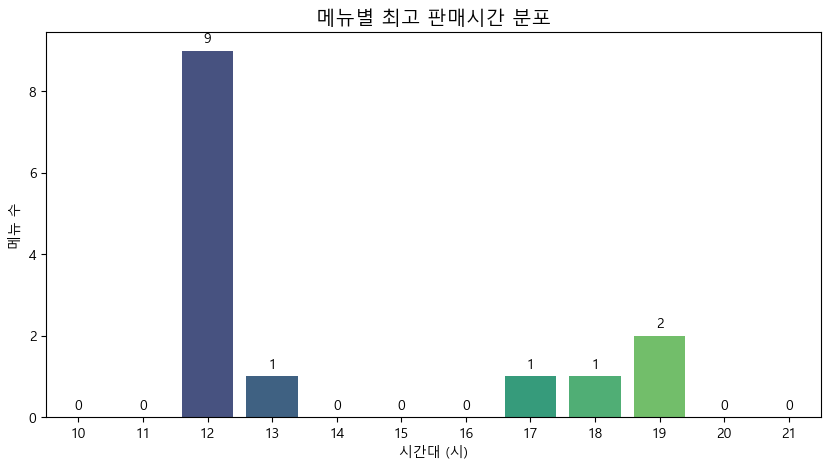

In [ ]:
# 각 메뉴별 최고점 시간 찾기
peak_times = menu_hourly_avg.loc[
    menu_hourly_avg.groupby("상품명")[0].idxmax()
][["상품명", "판매시간"]]

# 판매시간 정수형 변환
peak_times["판매시간"] = peak_times["판매시간"].astype(int)

# 시간대별 카운트 (10~21시 기준)
peak_count = peak_times["판매시간"].value_counts().reindex(range(10,22), fill_value=0)

# 시각화
plt.figure(figsize=(10,5))
sns.barplot(x=peak_count.index, y=peak_count.values, palette="viridis")
plt.title("메뉴별 최고 판매시간 분포", fontsize=14)
plt.xlabel("시간대 (시)")
plt.ylabel("메뉴 수")

# 카운트 숫자 표시
for idx, val in enumerate(peak_count.values):
    plt.text(idx, val + 0.2, str(val), ha='center')

plt.show()

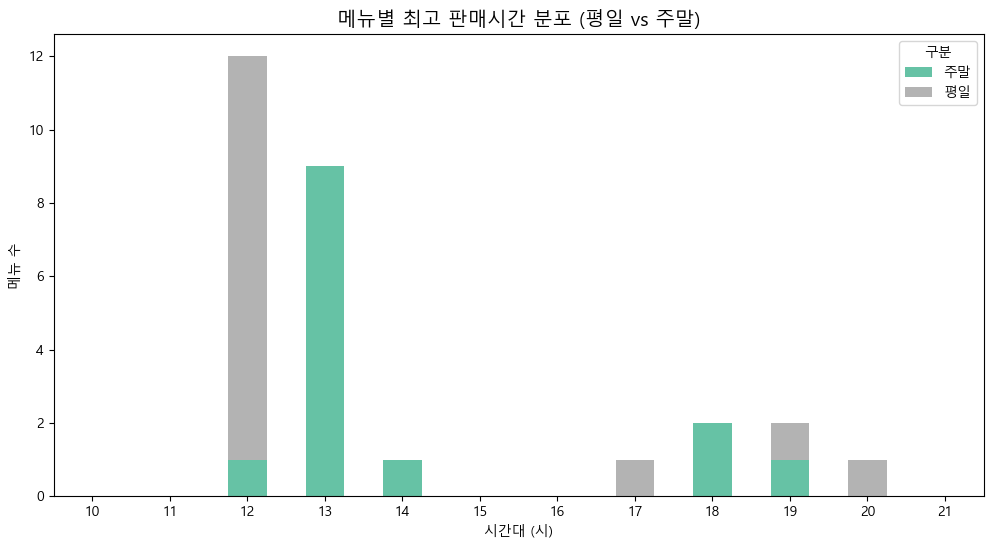

In [ ]:
# 판매일, 요일, 시간대 추출
df["판매일"] = pd.to_datetime(df["판매일시"]).dt.date
df["판매시간"] = pd.to_datetime(df["판매일시"]).dt.hour
df["요일번호"] = pd.to_datetime(df["판매일시"]).dt.dayofweek

# 평일/주말 구분
df["구분"] = df["요일번호"].apply(lambda x: "평일" if x < 5 else "주말")

# 10~22시 필터링
filtered = df[(df["판매시간"] >= 10) & (df["판매시간"] < 22)]

# 메뉴 × 시간대 × 구분별 평균 판매량
menu_hourly_group = (
    filtered.groupby(["상품명", "구분", "판매시간"])["수량"].sum() /
    filtered.groupby(["상품명", "구분", "판매시간"])["판매일"].nunique()
).reset_index(name="평균판매량")

# 메뉴 × 구분별 최고점 시간 찾기
peak_times_split = menu_hourly_group.loc[
    menu_hourly_group.groupby(["상품명","구분"])["평균판매량"].idxmax()
][["상품명", "구분", "판매시간"]]

# 평일/주말 각각 시간대 카운트
peak_count_split = (
    peak_times_split.groupby(["구분","판매시간"])
    .size()
    .unstack(fill_value=0)
    .reindex(columns=range(10,22), fill_value=0)
)

# 스택형 막대그래프
peak_count_split.T.plot(kind="bar", stacked=True, figsize=(12,6), colormap="Set2")

plt.title("메뉴별 최고 판매시간 분포 (평일 vs 주말)", fontsize=14)
plt.xlabel("시간대 (시)")
plt.ylabel("메뉴 수")
plt.xticks(rotation=0)
plt.legend(title="구분")
plt.show()


In [ ]:
# 메뉴 × 구분 × 시간대별 평균 판매량 (앞서 만든 menu_hourly_group 활용)
menu_hourly_group = (
    filtered.groupby(["상품명", "구분", "판매시간"])["수량"].sum() /
    filtered.groupby(["상품명", "구분", "판매시간"])["판매일"].nunique()
).reset_index(name="평균판매량")

# 평일 피크
weekday_peak = menu_hourly_group[menu_hourly_group["구분"]=="평일"].loc[
    lambda x: x.groupby("상품명")["평균판매량"].idxmax()
][["상품명","판매시간"]].rename(columns={"판매시간":"평일 피크"})

# 주말 피크
weekend_peak = menu_hourly_group[menu_hourly_group["구분"]=="주말"].loc[
    lambda x: x.groupby("상품명")["평균판매량"].idxmax()
][["상품명","판매시간"]].rename(columns={"판매시간":"주말 피크"})

# 병합
peak_compare = pd.merge(weekday_peak, weekend_peak, on="상품명", how="outer")

# 피크 동일 여부 표시
peak_compare["피크 동일여부"] = peak_compare["평일 피크"] == peak_compare["주말 피크"]

peak_compare


,상품명,평일 피크,주말 피크,피크 동일여부
0,가지솥밥,12,13,False
1,가지치즈솥밥,17,12,False
2,고등어솥밥,19,18,False
3,꽈리고추두부솥밥,12,13,False
4,마늘쫑솥밥,12,13,False
5,매운가지솥밥,12,18,False
6,매운가지치즈솥밥,12,13,False
7,소고기숙주솥밥,12,13,False
8,스테이크솥밥,12,13,False
9,연어솥밥,12,13,False


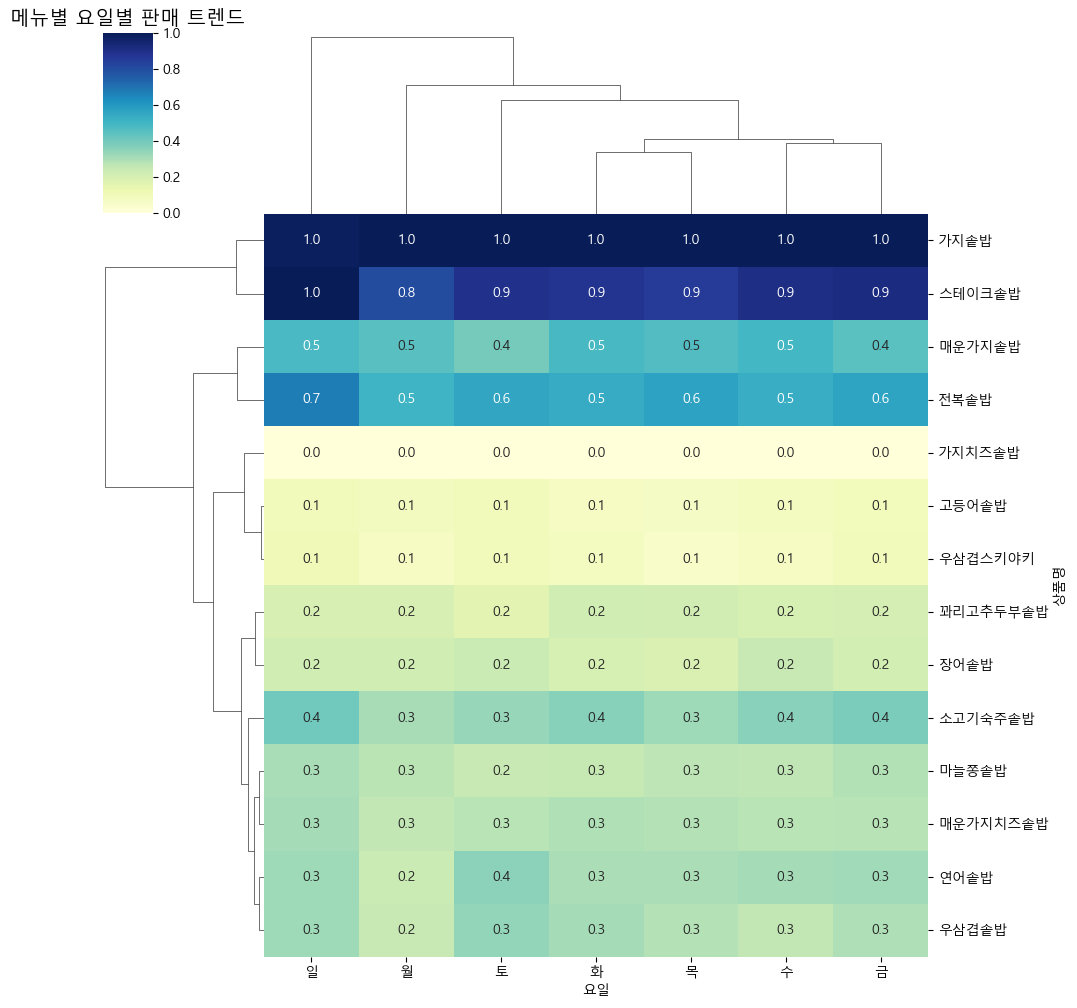

In [ ]:
# 요일 숫자(0=월 ~ 6=일)로 추출
df["요일번호"] = pd.to_datetime(df["판매일시"]).dt.dayofweek
weekday_map = {0:"월", 1:"화", 2:"수", 3:"목", 4:"금", 5:"토", 6:"일"}
df["요일"] = df["요일번호"].map(weekday_map)

# 요일별 평균 판매량 (총판매량 ÷ 해당 요일 일수)
weekday_total = df.groupby(["상품명","요일"])["수량"].sum()
weekday_days = df.groupby("요일")["판매일"].nunique()
weekday_avg = (weekday_total / weekday_total.index.get_level_values("요일").map(weekday_days)).unstack(fill_value=0)

# 메뉴 × 요일 매트릭스 (평균 판매량)
menu_weekday = weekday_avg[["월","화","수","목","금","토","일"]]

# 클러스터맵 (유사한 메뉴끼리 묶기)
sns.clustermap(menu_weekday, cmap="YlGnBu", standard_scale=1, annot=True, fmt=".1f")
plt.title("메뉴별 요일별 판매 트렌드", fontsize=14)
plt.show()


In [ ]:
# 요일별 평균 판매량 매트릭스 (앞에서 만든 것 활용)
menu_weekday = weekday_avg[["월","화","수","목","금","토","일"]]

# 계층적 클러스터링 수행
Z = linkage(menu_weekday, method='ward')

# 클러스터 개수 설정 (예: 3개 그룹)
labels = fcluster(Z, t=5, criterion='maxclust')

# 결과를 데이터프레임으로 정리
cluster_result = pd.DataFrame({
    "상품명": menu_weekday.index,
    "클러스터": labels
}).sort_values("클러스터")

cluster_result

,상품명,클러스터
0,가지솥밥,1
8,스테이크솥밥,1
2,고등어솥밥,2
1,가지치즈솥밥,2
11,우삼겹스키야키,2
13,전복솥밥,3
5,매운가지솥밥,3
3,꽈리고추두부솥밥,4
12,장어솥밥,4
7,소고기숙주솥밥,5


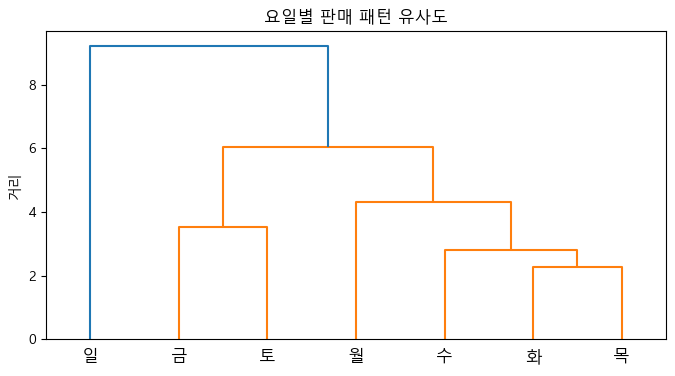

,요일,클러스터
5,토,1
4,금,1
1,화,2
2,수,2
3,목,2
0,월,3
6,일,4


In [ ]:
# 요일 × 메뉴
weekday_matrix = menu_weekday.T   # (7, 14)

# 계층적 클러스터링
Z = linkage(weekday_matrix.values, method="ward")

# 덴드로그램 시각화
plt.figure(figsize=(8,4))
dendrogram(Z, labels=weekday_matrix.index, leaf_rotation=0)
plt.title("요일별 판매 패턴 유사도")
plt.ylabel("거리")
plt.show()

# 4개 그룹으로 나누기
labels = fcluster(Z, t=4, criterion="maxclust")
weekday_cluster = pd.DataFrame({
    "요일": weekday_matrix.index,
    "클러스터": labels
}).sort_values("클러스터")

weekday_cluster


In [ ]:
# 1) 시그니처 메뉴 : '매운가지솥밥', '가지솥밥', '매운가지치즈솥밥' 
# 2) 인기 메뉴 : '가지솥밥', '스테이크솥밥' 
# 3) 채소 위주 메뉴 : '마늘쫑솥밥', '꽈리고추두부솥밥', '매운가지솥밥', '가지솥밥', '매운가지치즈솥밥' 
# 4) 생선 위주 메뉴 : '연어솥밥', '전복솥밥', '고등어솥밥', '장어솥밥' 
# 5) 육류 위주 메뉴 : '우삼겹솥밥', '소고기숙주솥밥', '스테이크솥밥' 
# 6) 비인기메뉴 : '우삼겹스키야키', '가지치즈솥밥' 
# 7) 솥밥이 아닌 메뉴 : '우삼겹스키야키' 
# 8) 신메뉴 : '우삼겹솥밥', '고등어솥밥'

# 4인석 : 1, 3, 4,5,6,7,12,13,14,15, 16, 17
# 2인석 : 2,8,9,10,11
# 벽 테이블: 5,6,13,14,15,16,17
# 모서리 테이블 : 5, 13,14,15,16,17
# # 중앙 테이블 : 6,7,8,9 
# # 입구 테이블 : 1,9, 10 
# # 화장실 앞 테이블 : 11,8

## 일시에 대한 트렌드가 비슷한 메뉴끼리의 클러스터링 및 임베딩

In [206]:
# 1. 사용자 정의 그룹 매핑
custom_groups = {
    "시그니처": ['매운가지솥밥', '가지솥밥', '매운가지치즈솥밥'],
    "인기": ['가지솥밥', '스테이크솥밥'],
    "채소": ['마늘쫑솥밥', '꽈리고추두부솥밥', '매운가지솥밥', '가지솥밥', '매운가지치즈솥밥'],
    "생선": ['연어솥밥', '전복솥밥', '고등어솥밥', '장어솥밥'],
    "육류": ['우삼겹솥밥', '소고기숙주솥밥', '스테이크솥밥'],
    "비인기": ['우삼겹스키야키', '가지치즈솥밥'],
    "솥밥아님": ['우삼겹스키야키'],
    "신메뉴": ['우삼겹솥밥', '고등어솥밥']
}

# 그룹 매핑용 DataFrame
group_rows = []
for group, menus in custom_groups.items():
    for menu in menus:
        group_rows.append({"상품명": menu, "그룹": group})
group_df = pd.DataFrame(group_rows)

# 2. peak_compare + cluster_result + group_df merge
merged = peak_compare.merge(cluster_result, on="상품명", how="left")
merged = merged.merge(group_df.groupby("상품명")["그룹"].apply(list).reset_index(), on="상품명", how="left")

# weekday_cluster는 요일 단위라서 직접 merge는 불가 → 나중에 요약 컬럼으로 붙일 수 있음
# 일단 메뉴별 설명 생성
def make_description(row):
    return f"{row['상품명']} | 평일피크={row['평일 피크']} | 주말피크={row['주말 피크']} | 클러스터={row['클러스터']} | 그룹={','.join(row['그룹']) if isinstance(row['그룹'], list) else ''}"

merged["설명"] = merged.apply(make_description, axis=1)

merged[["상품명", "설명"]]


,상품명,설명
0,가지솥밥,"가지솥밥 | 평일피크=12 | 주말피크=13 | 클러스터=1 | 그룹=시그니처,인기,채소"
1,가지치즈솥밥,가지치즈솥밥 | 평일피크=17 | 주말피크=12 | 클러스터=2 | 그룹=비인기
2,고등어솥밥,"고등어솥밥 | 평일피크=19 | 주말피크=18 | 클러스터=2 | 그룹=생선,신메뉴"
3,꽈리고추두부솥밥,꽈리고추두부솥밥 | 평일피크=12 | 주말피크=13 | 클러스터=4 | 그룹=채소
4,마늘쫑솥밥,마늘쫑솥밥 | 평일피크=12 | 주말피크=13 | 클러스터=5 | 그룹=채소
5,매운가지솥밥,"매운가지솥밥 | 평일피크=12 | 주말피크=18 | 클러스터=3 | 그룹=시그니처,채소"
6,매운가지치즈솥밥,매운가지치즈솥밥 | 평일피크=12 | 주말피크=13 | 클러스터=5 | 그룹=시그니...
7,소고기숙주솥밥,소고기숙주솥밥 | 평일피크=12 | 주말피크=13 | 클러스터=5 | 그룹=육류
8,스테이크솥밥,"스테이크솥밥 | 평일피크=12 | 주말피크=13 | 클러스터=1 | 그룹=인기,육류"
9,연어솥밥,연어솥밥 | 평일피크=12 | 주말피크=13 | 클러스터=5 | 그룹=생선


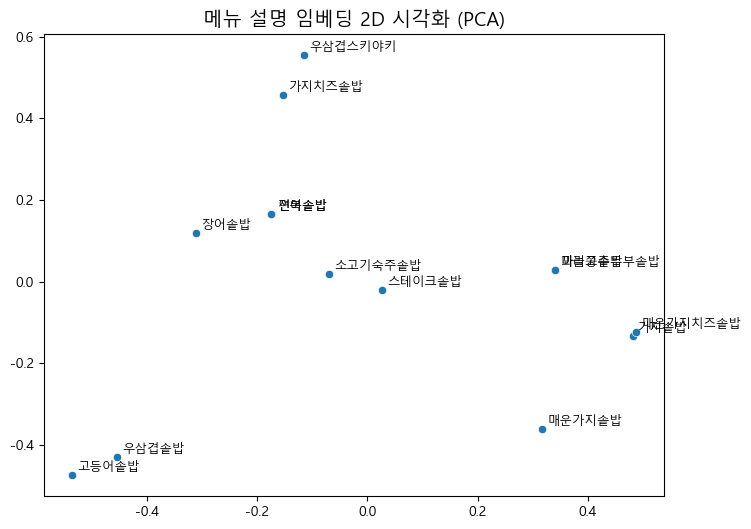

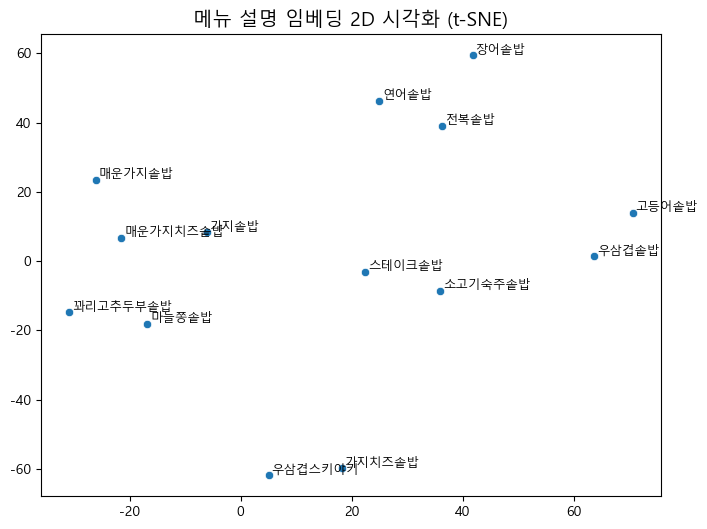

In [208]:
# 설명 텍스트
texts = merged["설명"].tolist()
menus = merged["상품명"].tolist()

# 1. TF-IDF 벡터화
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(texts)

# 2. 차원 축소 (t-SNE, PCA)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.toarray())

# t-SNE (조금 더 퍼짐)
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())

# 3. 시각화 - PCA
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1])
for i, menu in enumerate(menus):
    plt.text(X_pca[i,0]+0.01, X_pca[i,1]+0.01, menu, fontsize=9)
plt.title("메뉴 설명 임베딩 2D 시각화 (PCA)", fontsize=14)
plt.show()

# 4. 시각화 - t-SNE
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1])
for i, menu in enumerate(menus):
    plt.text(X_tsne[i,0]+0.5, X_tsne[i,1]+0.5, menu, fontsize=9)
plt.title("메뉴 설명 임베딩 2D 시각화 (t-SNE)", fontsize=14)
plt.show()


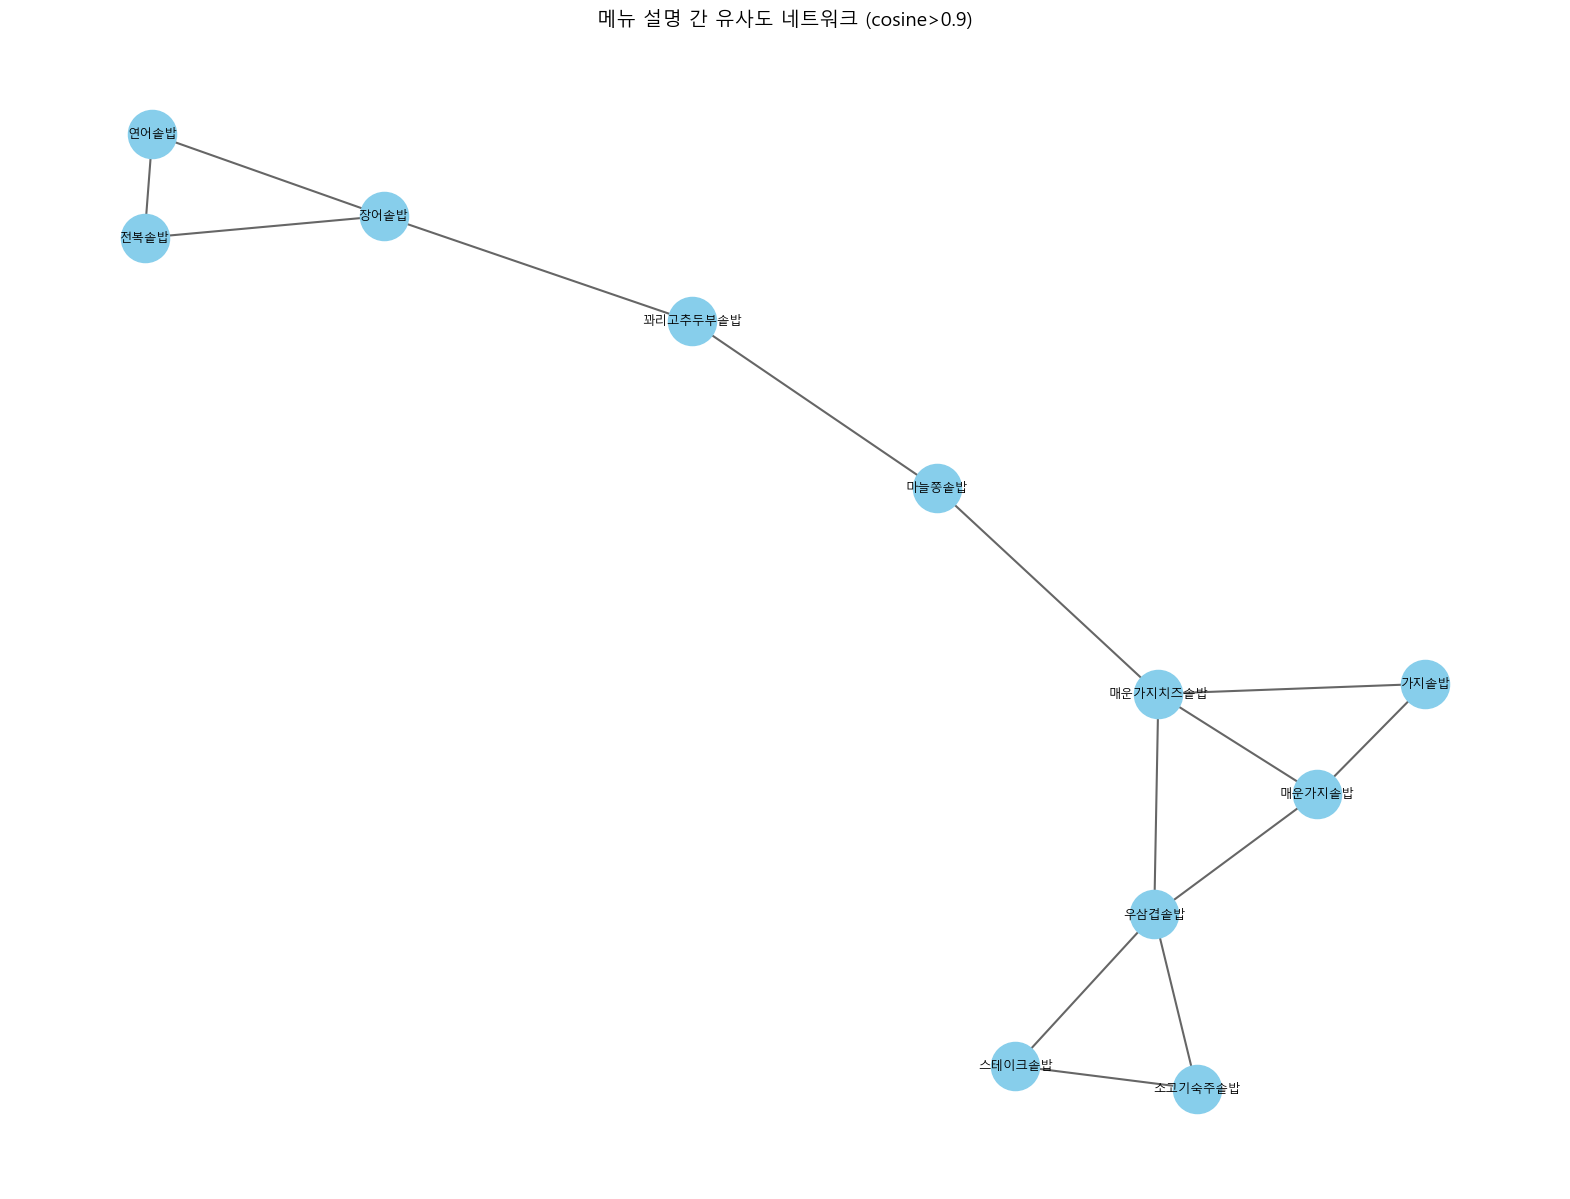

In [211]:
model = SentenceTransformer("snunlp/KR-SBERT-V40K-klueNLI-augSTS")

desc_embeddings = model.encode(merged["설명"].tolist(), convert_to_tensor=True)
sim_matrix = cosine_similarity(desc_embeddings.cpu().numpy())

# 유사도 행렬 → 네트워크 그래프 변환
G = nx.Graph()
for i, desc1 in enumerate(merged["설명"]):
    for j, desc2 in enumerate(merged["설명"]):
        if i < j and sim_matrix[i, j] > 0.9:
            G.add_edge(merged["상품명"].iloc[i], merged["상품명"].iloc[j], weight=sim_matrix[i, j])

# 시각화
plt.figure(figsize=(20,15))
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_nodes(G, pos, node_color="skyblue", node_size=1200)
nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.6)
nx.draw_networkx_labels(G, pos, font_family="Malgun Gothic", font_size=9)
plt.title("메뉴 설명 간 유사도 네트워크 (cosine>0.9)", fontsize=14)
plt.axis("off")
plt.show()


In [ ]:
# 한국어 지원 모델 로드 (예: KoSentenceBERT)
model = SentenceTransformer("snunlp/KR-SBERT-V40K-klueNLI-augSTS")

# 설명 컬럼 임베딩 (384차원 벡터)
embeddings = model.encode(merged["설명"].tolist(), convert_to_numpy=True)

# DataFrame에 추가
merged["상품명_임베딩"] = embeddings.tolist()

# 확인
print(merged[["상품명", "상품명_임베딩"]].head())

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

c:\Users\skg46\AppData\Local\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\skg46\.cache\huggingface\hub\models--snunlp--KR-SBERT-V40K-klueNLI-augSTS. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/467M [00:00<?, ?B/s]

        상품명                                            상품명_임베딩
0      가지솥밥  [-0.6075161695480347, -0.8168693780899048, -0....
1    가지치즈솥밥  [-0.2937808036804199, -0.799403190612793, -0.6...
2     고등어솥밥  [-0.3905492126941681, -1.0794819593429565, -1....
3  꽈리고추두부솥밥  [-0.3450201749801636, -0.8549972772598267, -0....
4     마늘쫑솥밥  [-0.7713304162025452, -0.7743890285491943, -0....


In [ ]:
merged

,상품명,평일 피크,주말 피크,피크 동일여부,클러스터,그룹,설명,상품명_임베딩
0,가지솥밥,12,13,False,1,"[시그니처, 인기, 채소]","가지솥밥 | 평일피크=12 | 주말피크=13 | 클러스터=1 | 그룹=시그니처,인기,채소","[-0.6075161695480347, -0.8168693780899048, -0...."
1,가지치즈솥밥,17,12,False,2,[비인기],가지치즈솥밥 | 평일피크=17 | 주말피크=12 | 클러스터=2 | 그룹=비인기,"[-0.2937808036804199, -0.799403190612793, -0.6..."
2,고등어솥밥,19,18,False,2,"[생선, 신메뉴]","고등어솥밥 | 평일피크=19 | 주말피크=18 | 클러스터=2 | 그룹=생선,신메뉴","[-0.3905492126941681, -1.0794819593429565, -1...."
3,꽈리고추두부솥밥,12,13,False,4,[채소],꽈리고추두부솥밥 | 평일피크=12 | 주말피크=13 | 클러스터=4 | 그룹=채소,"[-0.3450201749801636, -0.8549972772598267, -0...."
4,마늘쫑솥밥,12,13,False,5,[채소],마늘쫑솥밥 | 평일피크=12 | 주말피크=13 | 클러스터=5 | 그룹=채소,"[-0.7713304162025452, -0.7743890285491943, -0...."
5,매운가지솥밥,12,18,False,3,"[시그니처, 채소]","매운가지솥밥 | 평일피크=12 | 주말피크=18 | 클러스터=3 | 그룹=시그니처,채소","[-0.6130760908126831, -0.6787370443344116, -0...."
6,매운가지치즈솥밥,12,13,False,5,"[시그니처, 채소]",매운가지치즈솥밥 | 평일피크=12 | 주말피크=13 | 클러스터=5 | 그룹=시그니...,"[-0.6551783084869385, -0.888046145439148, -0.6..."
7,소고기숙주솥밥,12,13,False,5,[육류],소고기숙주솥밥 | 평일피크=12 | 주말피크=13 | 클러스터=5 | 그룹=육류,"[-0.5264214873313904, -0.5856020450592041, -0...."
8,스테이크솥밥,12,13,False,1,"[인기, 육류]","스테이크솥밥 | 평일피크=12 | 주말피크=13 | 클러스터=1 | 그룹=인기,육류","[-0.7418605089187622, -0.561369776725769, -0.7..."
9,연어솥밥,12,13,False,5,[생선],연어솥밥 | 평일피크=12 | 주말피크=13 | 클러스터=5 | 그룹=생선,"[-0.4723758399486542, -0.9281578660011292, -0...."


## 테이블에 대한 상세 정보 및 트렌드 정보를 포함한 메뉴 임베딩

C:\Users\skg46\AppData\Local\Temp\ipykernel_8060\3281476599.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=table_total, x="테이블코드", y="수량", palette="viridis")


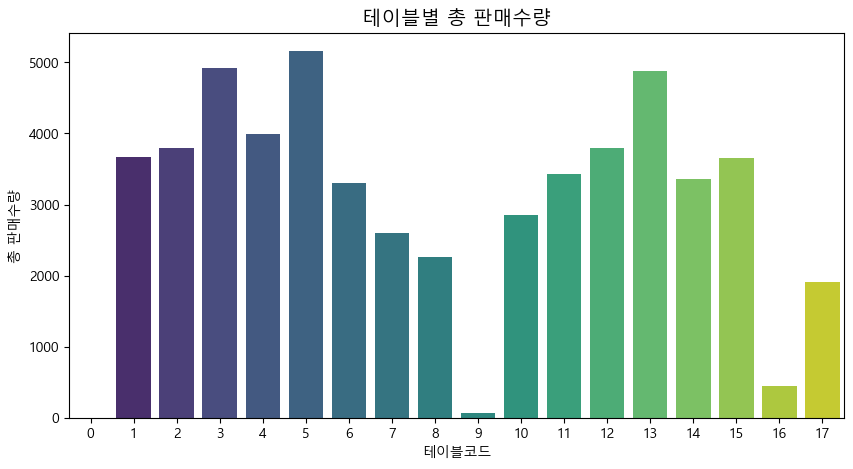

In [ ]:
table_total = df.groupby("테이블코드")["수량"].sum().reset_index()
plt.figure(figsize=(10,5))
sns.barplot(data=table_total, x="테이블코드", y="수량", palette="viridis")
plt.title("테이블별 총 판매수량", fontsize=14)
plt.xlabel("테이블코드")
plt.ylabel("총 판매수량")
plt.show()

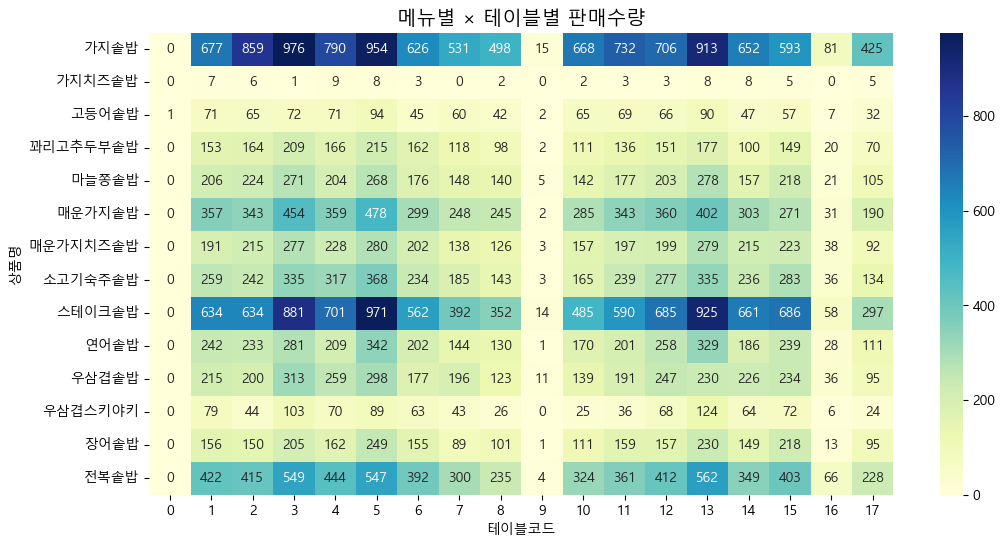

In [ ]:
menu_table = df.groupby(["상품명","테이블코드"])["수량"].sum().reset_index()
pivot = menu_table.pivot(index="상품명", columns="테이블코드", values="수량").fillna(0)
plt.figure(figsize=(12,6))
sns.heatmap(pivot, cmap="YlGnBu", annot=True, fmt=".0f")
plt.title("메뉴별 × 테이블별 판매수량", fontsize=14)
plt.xlabel("테이블코드")
plt.ylabel("상품명")
plt.show()

In [212]:
# 테이블별 메타데이터 생성
meta = []
for t in range(1, 18):
    # 좌석유형
    seat_type = "4인석" if t in [1,3,4,5,6,7,12,13,14,15,16,17] else "2인석"
    # 벽 여부
    wall = "벽" if t in [5,6,13,14,15,16,17] else "일반"
    # 모서리 여부
    corner = "모서리" if t in [5,13,14,15,16,17] else "일반"
    # 중앙 여부
    center = "중앙" if t in [6,7,8,9] else "일반"
    # 입구 여부
    entrance = "입구" if t in [1,9,10] else "일반"
    # 화장실 앞 여부
    toilet = "화장실앞" if t in [11,8] else "일반"

    meta.append({
        "테이블코드": t,
        "좌석유형": seat_type,
        "벽여부": wall,
        "모서리여부": corner,
        "중앙여부": center,
        "입구여부": entrance,
        "화장실앞여부": toilet
    })

table_meta = pd.DataFrame(meta)

In [213]:
# 1. 테이블별 속성 DataFrame 만들기
meta = []
for t in range(1, 18):
    seat_type = "4인석" if t in [1,3,4,5,6,7,12,13,14,15,16,17] else "2인석"
    wall = "벽" if t in [5,6,13,14,15,16,17] else "일반"
    corner = "모서리" if t in [5,13,14,15,16,17] else "일반"
    meta.append({"테이블코드": t, "좌석유형": seat_type, "벽여부": wall, "모서리여부": corner})

table_meta = pd.DataFrame(meta)

# 2. 메뉴 × 테이블 판매량
menu_table = df.groupby(["상품명","테이블코드"])["수량"].sum().reset_index()

# 3. 테이블 속성 join
menu_table_meta = menu_table.merge(table_meta, on="테이블코드", how="left")

table_total = df.groupby("테이블코드")["수량"].sum().reset_index()
top_table = table_total.sort_values("수량", ascending=False)
top_table = top_table.merge(table_meta, on="테이블코드", how="left")

In [214]:
# 숫자형 컬럼만 추출
num_cols = pivot.select_dtypes(include=["number"]).columns

def top5_tables(row):
    top5 = row[num_cols].sort_values(ascending=False).head(5)
    return list(top5.index.astype(int))  # 테이블코드를 int로 변환해서 리스트 반환

pivot["Top5_테이블"] = pivot.apply(top5_tables, axis=1)

print(pivot[["Top5_테이블"]].head())

테이블코드              Top5_테이블
상품명                        
가지솥밥       [3, 5, 13, 2, 4]
가지치즈솥밥    [4, 5, 13, 14, 1]
고등어솥밥      [5, 13, 3, 4, 1]
꽈리고추두부솥밥   [5, 3, 13, 4, 2]
마늘쫑솥밥     [13, 3, 5, 2, 15]


In [215]:
merged# 1. 베이스: peak_compare
merged = peak_compare.copy()

# 2. 메뉴별 클러스터 결과 붙이기
merged = merged.merge(cluster_result, on="상품명", how="left")

# 3. 그룹 정보 붙이기
merged = merged.merge(
    group_df.groupby("상품명")["그룹"].apply(list).reset_index(),
    on="상품명", how="left"
)

# 4. Top5 테이블 붙이기
merged = merged.merge(
    pivot[["Top5_테이블"]].reset_index(),
    on="상품명", how="left"
)

# 5. Top5 테이블에 table_meta 설명 녹여내기
def map_table_meta(table_list, meta):
    if not isinstance(table_list, list):
        return []
    return [
        {
            "테이블코드": t,
            "좌석유형": meta.loc[meta["테이블코드"]==t, "좌석유형"].values[0],
            "벽여부": meta.loc[meta["테이블코드"]==t, "벽여부"].values[0],
            "모서리여부": meta.loc[meta["테이블코드"]==t, "모서리여부"].values[0],
        }
        for t in table_list if t in meta["테이블코드"].values
    ]

merged["Top5_테이블_특성"] = merged["Top5_테이블"].apply(lambda x: map_table_meta(x, table_meta))

In [216]:
def make_full_description(row):
    groups = ",".join(row["그룹"]) if isinstance(row["그룹"], list) else ""
    top5_tables = ",".join(map(str, row["Top5_테이블"])) if isinstance(row["Top5_테이블"], list) else ""
    
    # 테이블 특성까지 포함
    table_meta_desc = []
    if isinstance(row["Top5_테이블_특성"], list):
        for t in row["Top5_테이블_특성"]:
            desc = f"{t['테이블코드']}({t['좌석유형']},벽={t['벽여부']},모서리={t['모서리여부']})"
            table_meta_desc.append(desc)
    table_meta_desc = ";".join(table_meta_desc)

    return (
        f"{row['상품명']} | 평일피크={row['평일 피크']} | 주말피크={row['주말 피크']} "
        f"| 피크동일여부={row['피크 동일여부']} | 클러스터={row['클러스터']} "
        f"| 그룹={groups} | Top5테이블={top5_tables} "
        f"| Top5테이블특성={table_meta_desc}"
    )

merged["설명"] = merged.apply(make_full_description, axis=1)

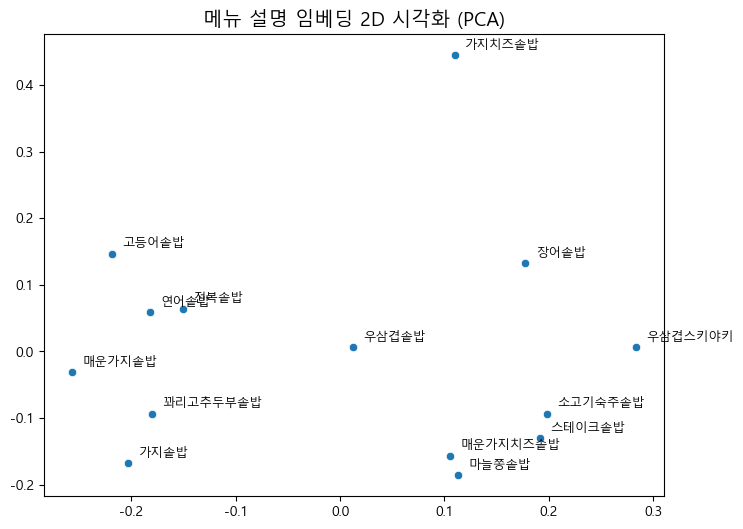

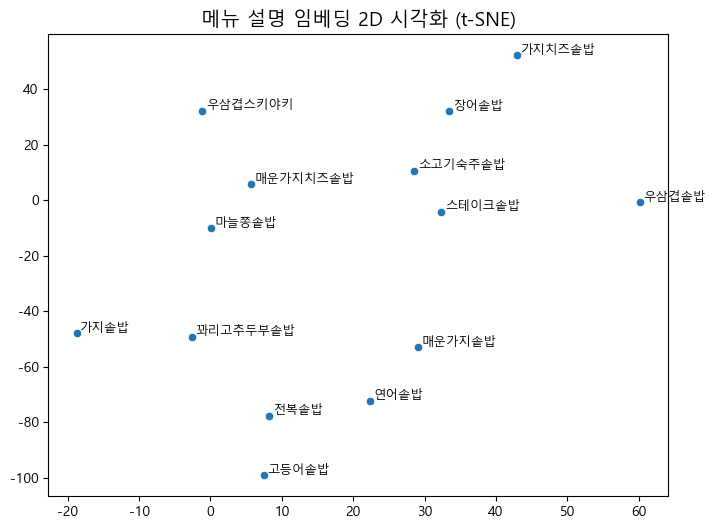

In [217]:
# 설명 텍스트
texts = merged["설명"].tolist()
menus = merged["상품명"].tolist()

# 1. TF-IDF 벡터화
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(texts)

# 2. 차원 축소 (t-SNE, PCA)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.toarray())

# t-SNE (조금 더 퍼짐)
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())

# 3. 시각화 - PCA
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1])
for i, menu in enumerate(menus):
    plt.text(X_pca[i,0]+0.01, X_pca[i,1]+0.01, menu, fontsize=9)
plt.title("메뉴 설명 임베딩 2D 시각화 (PCA)", fontsize=14)
plt.show()

# 4. 시각화 - t-SNE
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1])
for i, menu in enumerate(menus):
    plt.text(X_tsne[i,0]+0.5, X_tsne[i,1]+0.5, menu, fontsize=9)
plt.title("메뉴 설명 임베딩 2D 시각화 (t-SNE)", fontsize=14)
plt.show()

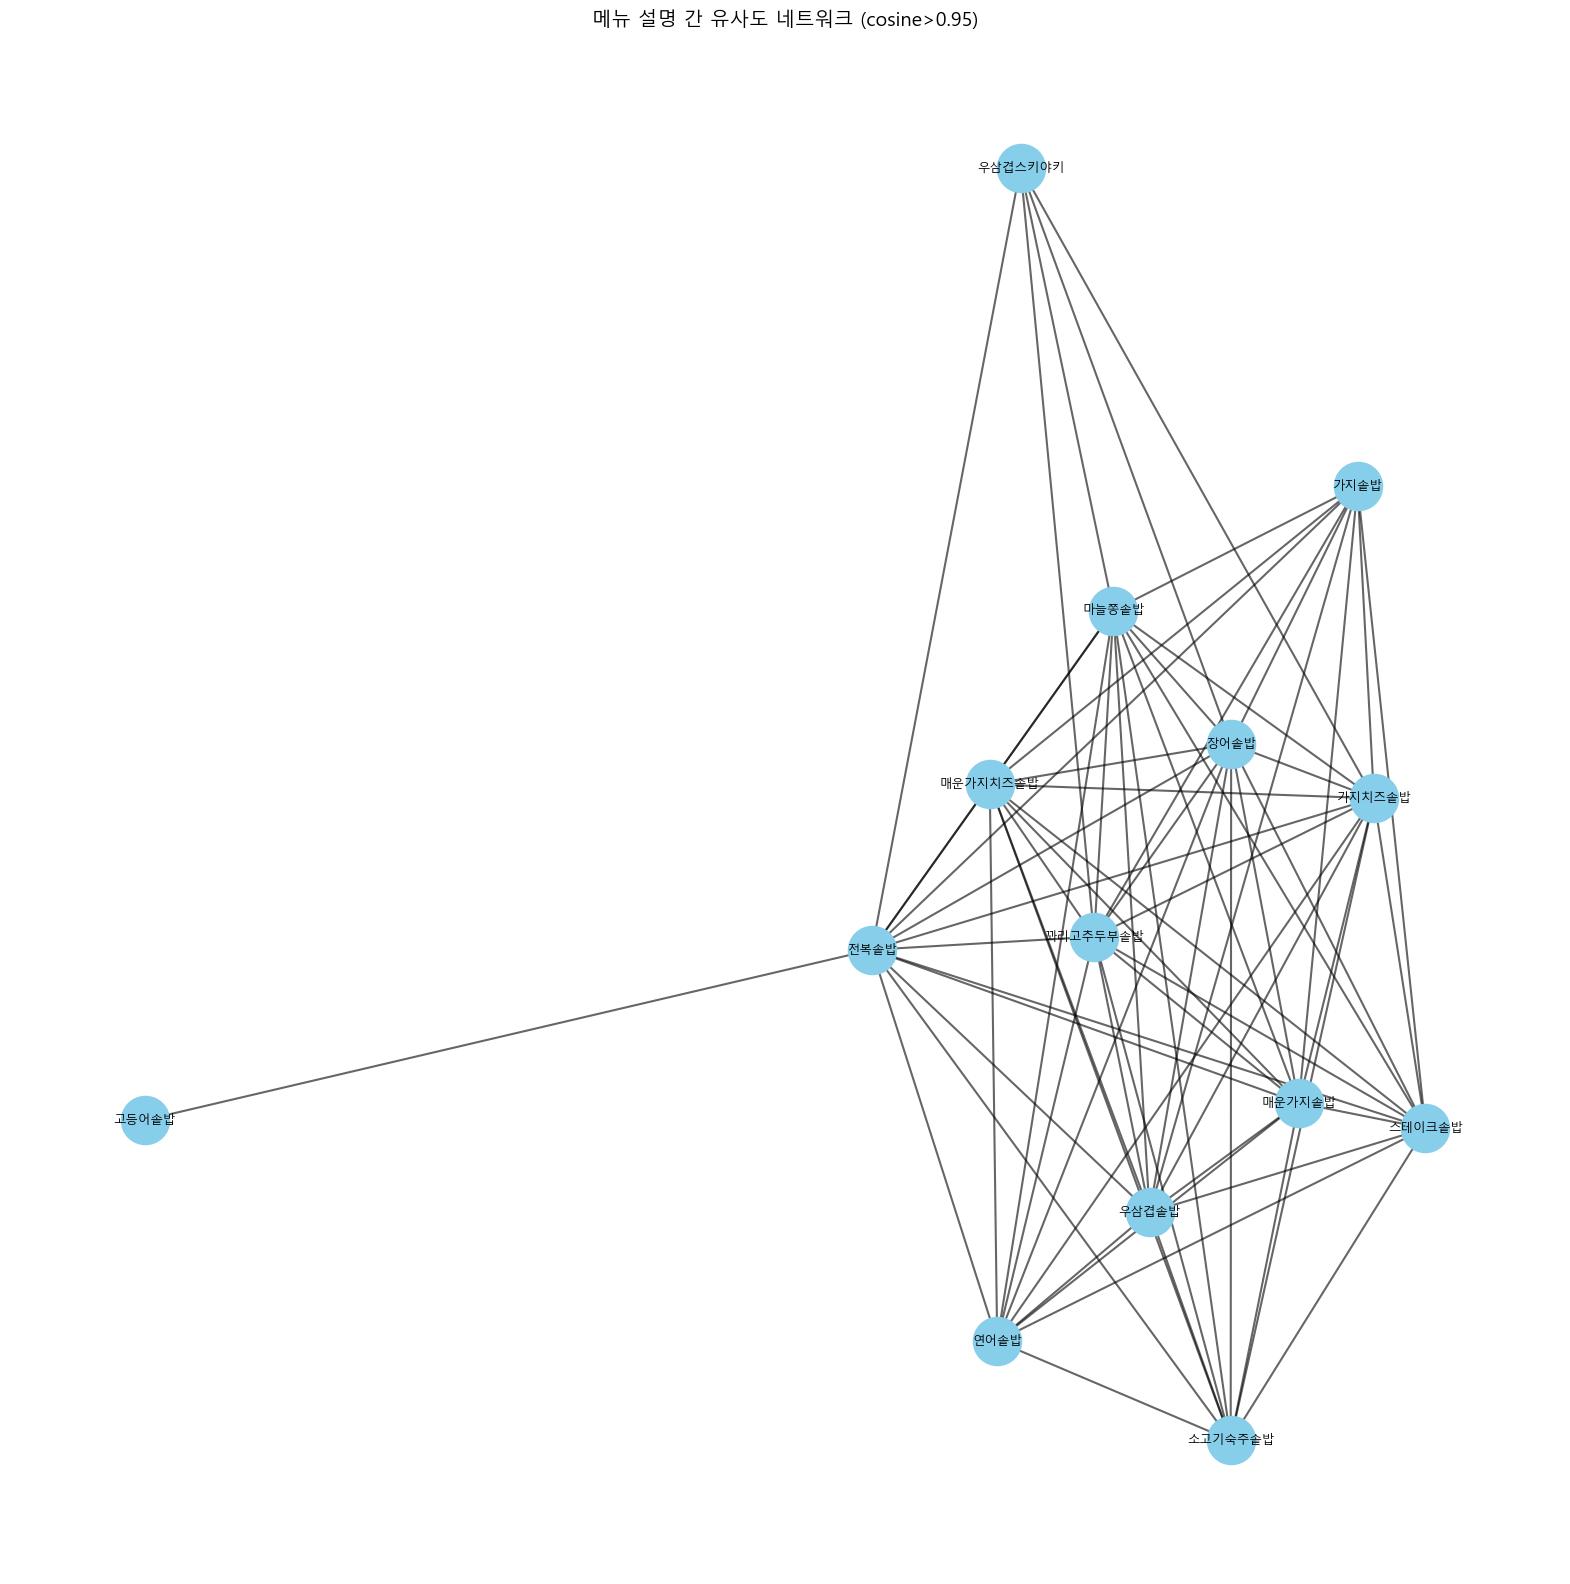

In [221]:
model = SentenceTransformer("snunlp/KR-SBERT-V40K-klueNLI-augSTS")

desc_embeddings = model.encode(merged["설명"].tolist(), convert_to_tensor=True)
sim_matrix = cosine_similarity(desc_embeddings.cpu().numpy())

# 유사도 행렬 → 네트워크 그래프 변환
G = nx.Graph()
for i, desc1 in enumerate(merged["설명"]):
    for j, desc2 in enumerate(merged["설명"]):
        if i < j and sim_matrix[i, j] > 0.95:
            G.add_edge(merged["상품명"].iloc[i], merged["상품명"].iloc[j], weight=sim_matrix[i, j])

# 시각화
plt.figure(figsize=(20,20))
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_nodes(G, pos, node_color="skyblue", node_size=1200)
nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.6)
nx.draw_networkx_labels(G, pos, font_family="Malgun Gothic", font_size=9)
plt.title("메뉴 설명 간 유사도 네트워크 (cosine>0.95)", fontsize=14)
plt.axis("off")
plt.show()

## 테이블에 대한 주말 여부에 따른 트렌드 정보를 포함한 메뉴 임베딩

In [222]:
df["요일"] = pd.to_datetime(df["판매일시"]).dt.dayofweek
df["주말여부"] = df["요일"].apply(lambda x: "주말" if x >= 5 else "평일")


menu_table_wd = (
    df.groupby(["주말여부","상품명","테이블코드"])["수량"].sum().reset_index()
)

pivot_wd = menu_table_wd.pivot_table(
    index="상품명", columns=["주말여부","테이블코드"], values="수량", fill_value=0
).reset_index()

In [223]:
pivot_wd.reset_index()

주말여부  index       상품명   주말                                                   \
테이블코드                    0      1      2      3      4      5      6      7   
0         0      가지솥밥  0.0  176.0  220.0  282.0  217.0  274.0  163.0  133.0   
1         1    가지치즈솥밥  0.0    1.0    1.0    1.0    1.0    0.0    0.0    0.0   
2         2     고등어솥밥  1.0   15.0   19.0   17.0   28.0   30.0   13.0   17.0   
3         3  꽈리고추두부솥밥  0.0   42.0   43.0   55.0   29.0   56.0   34.0   31.0   
4         4     마늘쫑솥밥  0.0   55.0   55.0   73.0   60.0   89.0   37.0   33.0   
5         5    매운가지솥밥  0.0   84.0  101.0  127.0   80.0  126.0   71.0   52.0   
6         6  매운가지치즈솥밥  0.0   50.0   52.0   72.0   66.0   88.0   54.0   32.0   
7         7   소고기숙주솥밥  0.0   72.0   61.0   88.0   94.0  111.0   71.0   51.0   
8         8    스테이크솥밥  0.0  157.0  178.0  267.0  216.0  291.0  161.0  107.0   
9         9      연어솥밥  0.0   56.0   64.0   89.0   50.0  100.0   68.0   34.0   
10       10     우삼겹솥밥  0.0   56.0   66.0   93.0   80.0   93.0   44.0   51.0   
11       11   우삼겹스키야키  0.0   25.0   13.0   28.0   31.0   23.0   23.0   12.0   
12       12      장어솥밥  0.0   40.0   36.0   56.0   50.0   75.0   46.0   18.0   
13       13      전복솥밥  0.0  117.0  122.0  169.0  138.0  163.0  127.0   75.0   

주말여부   ...     평일                                                               
테이블코드  ...      8     9     10     11     12     13     14     15    16     17  
0      ...  390.0  12.0  490.0  539.0  508.0  660.0  472.0  422.0  71.0  349.0  
1      ...    1.0   0.0    2.0    3.0    3.0    5.0    8.0    5.0   0.0    2.0  
2      ...   30.0   1.0   44.0   49.0   44.0   59.0   34.0   41.0   7.0   25.0  
3      ...   73.0   2.0   87.0  109.0  116.0  138.0   73.0  111.0  20.0   62.0  
4      ...  107.0   4.0  110.0  134.0  152.0  194.0  100.0  157.0  20.0   81.0  
5      ...  188.0   1.0  222.0  244.0  269.0  294.0  237.0  201.0  25.0  147.0  
6      ...   98.0   2.0  119.0  151.0  138.0  185.0  155.0  153.0  30.0   72.0  
7      ...  121.0   2.0  124.0  172.0  193.0  232.0  162.0  202.0  33.0  109.0  
8      ...  267.0   5.0  351.0  426.0  484.0  635.0  495.0  488.0  53.0  238.0  
9      ...   98.0   1.0  119.0  144.0  181.0  214.0  125.0  158.0  22.0   82.0  
10     ...   87.0   7.0   99.0  123.0  170.0  157.0  157.0  152.0  33.0   72.0  
11     ...   13.0   0.0   15.0   22.0   47.0   91.0   46.0   39.0   4.0   19.0  
12     ...   74.0   0.0   78.0  117.0  111.0  161.0  104.0  163.0  10.0   74.0  
13     ...  184.0   1.0  256.0  243.0  294.0  405.0  258.0  265.0  56.0  146.0  

[14 rows x 37 columns]

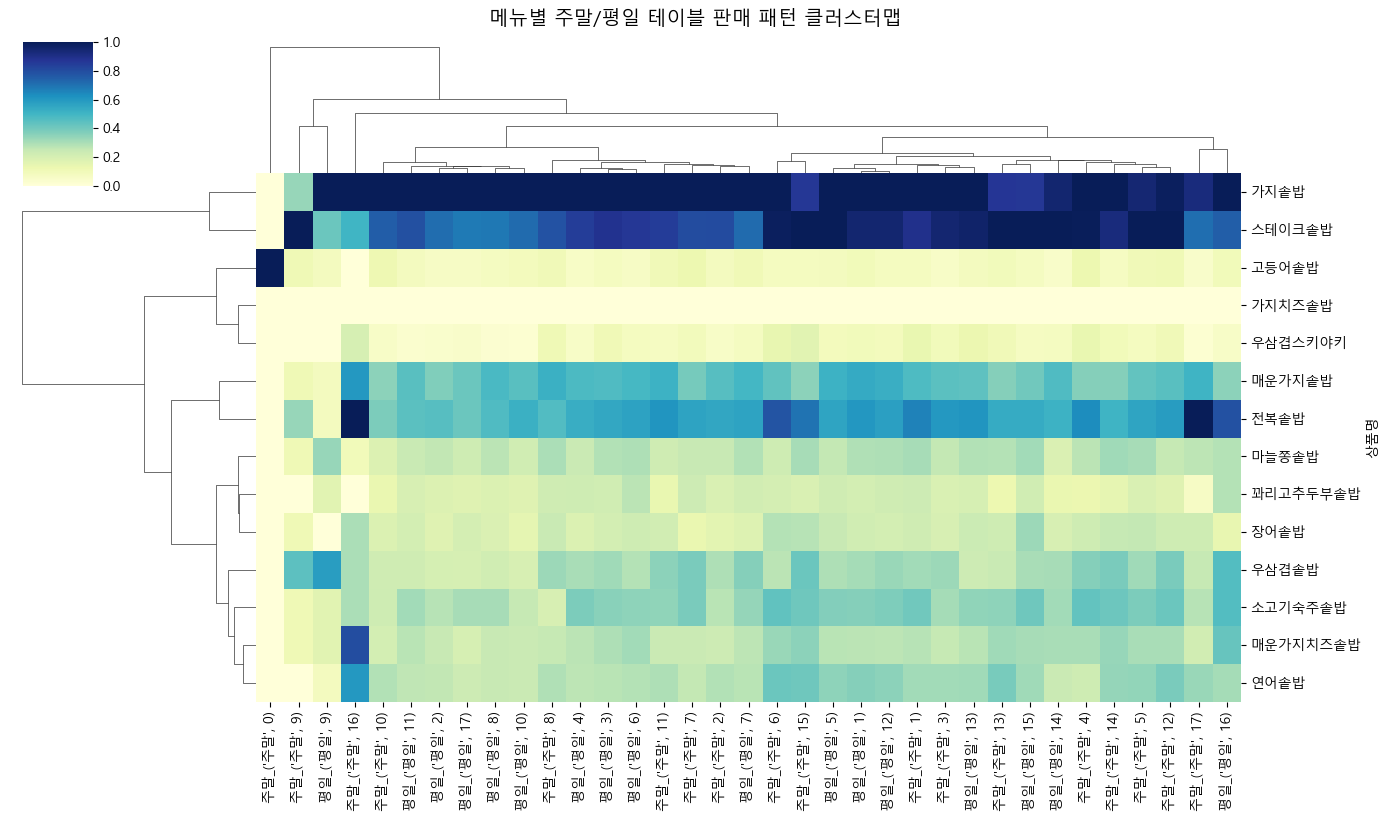

In [224]:
# 1. 주말/평일 데이터 합치기
weekend_data = pivot_wd.loc[:, pd.IndexSlice["주말", :]]
weekday_data = pivot_wd.loc[:, pd.IndexSlice["평일", :]]

# 컬럼 이름에 구분 추가
weekend_data.columns = [f"주말_{c}" for c in weekend_data.columns]
weekday_data.columns = [f"평일_{c}" for c in weekday_data.columns]

# 2. 합치기
menu_vectors = pd.concat([weekend_data, weekday_data], axis=1)
menu_vectors.index = pivot_wd["상품명"]

# 3. 클러스터맵 시각화
sns.clustermap(
    menu_vectors,
    cmap="YlGnBu",
    standard_scale=1,  # 메뉴별로 표준화
    figsize=(14, 8),
    method="ward",
    metric="euclidean"
)

plt.suptitle("메뉴별 주말/평일 테이블 판매 패턴 클러스터맵", y=1.02, fontsize=14)
plt.show()

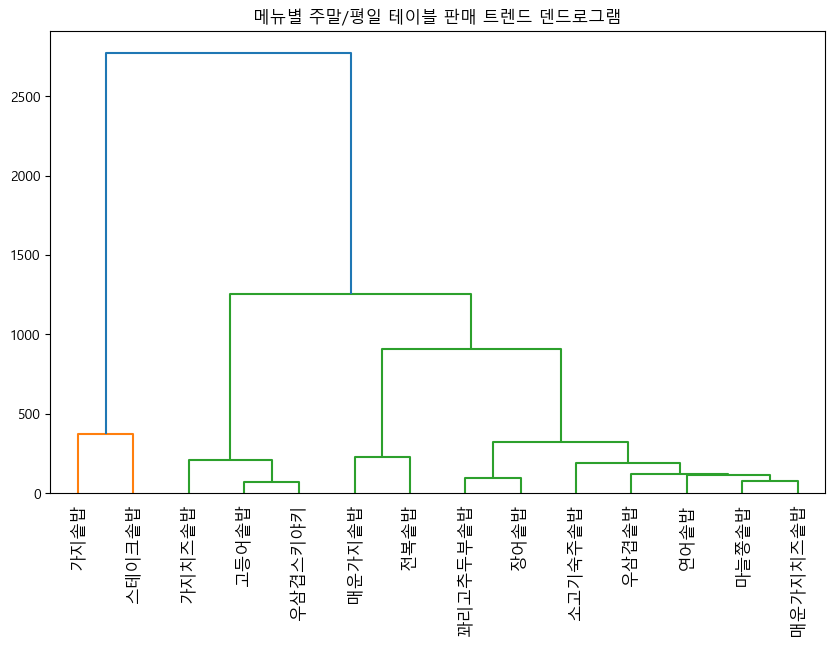

주말여부        상품명 클러스터_주말평일패턴
테이블코드                      
0          가지솥밥           1
1        가지치즈솥밥           2
2         고등어솥밥           2
3      꽈리고추두부솥밥           4
4         마늘쫑솥밥           4
5        매운가지솥밥           3
6      매운가지치즈솥밥           4
7       소고기숙주솥밥           4
8        스테이크솥밥           1
9          연어솥밥           4
10        우삼겹솥밥           4
11      우삼겹스키야키           2
12         장어솥밥           4
13         전복솥밥           3


In [225]:
# 1. 숫자형 데이터만 추출 (주말/평일 테이블 판매량)
num_cols = [c for c in pivot_wd.columns if isinstance(c, int)]  # 테이블코드
weekend_data = pivot_wd.loc[:, pd.IndexSlice["주말", :]]
weekday_data = pivot_wd.loc[:, pd.IndexSlice["평일", :]]

# 2. 주말 + 평일 벡터 결합
menu_vectors = pd.concat([weekend_data, weekday_data], axis=1)
menu_vectors.index = pivot_wd["상품명"]

# 3. 계층적 클러스터링 수행
Z = linkage(menu_vectors.values, method="ward")
labels = fcluster(Z, t=4, criterion="maxclust")  # 군집 개수 4개 예시
pivot_wd["클러스터_주말평일패턴"] = labels

# 4. 덴드로그램 시각화
plt.figure(figsize=(10,6))
dendrogram(Z, labels=menu_vectors.index, leaf_rotation=90)
plt.title("메뉴별 주말/평일 테이블 판매 트렌드 덴드로그램")
plt.show()

# 결과 확인
print(pivot_wd[["상품명", "클러스터_주말평일패턴"]])

In [226]:
# MultiIndex → 단일 컬럼으로 변환
pivot_wd_flat = pivot_wd.copy()
pivot_wd_flat.columns = [col[0] if col[0] != "" else col[1] for col in pivot_wd_flat.columns]

# 확인
print(pivot_wd_flat.columns)

# 필요한 컬럼만 추출
pattern_cluster = pivot_wd_flat[["상품명", "클러스터_주말평일패턴"]].drop_duplicates()

# merged에 병합
merged = merged.merge(pattern_cluster, on="상품명", how="left")

# 설명 다시 업데이트
def make_description(row):
    return (
        f"{row['상품명']} | "
        f"평일피크={row['평일 피크']} | "
        f"주말피크={row['주말 피크']} | "
        f"피크동일여부={row['피크 동일여부']} | "
        f"클러스터={row['클러스터']} | "
        f"주말평일패턴={row['클러스터_주말평일패턴']} | "
        f"그룹={','.join(row['그룹']) if isinstance(row['그룹'], list) else ''}"
    )

merged["설명"] = merged.apply(make_description, axis=1)

# 확인
print(merged[["상품명", "설명"]].head())

Index(['상품명', '주말', '주말', '주말', '주말', '주말', '주말', '주말', '주말', '주말', '주말', '주말',
       '주말', '주말', '주말', '주말', '주말', '주말', '주말', '평일', '평일', '평일', '평일', '평일',
       '평일', '평일', '평일', '평일', '평일', '평일', '평일', '평일', '평일', '평일', '평일', '평일',
       '클러스터_주말평일패턴'],
      dtype='object')
        상품명                                                 설명
0      가지솥밥  가지솥밥 | 평일피크=12 | 주말피크=13 | 피크동일여부=False | 클러스터...
1    가지치즈솥밥  가지치즈솥밥 | 평일피크=17 | 주말피크=12 | 피크동일여부=False | 클러...
2     고등어솥밥  고등어솥밥 | 평일피크=19 | 주말피크=18 | 피크동일여부=False | 클러스...
3  꽈리고추두부솥밥  꽈리고추두부솥밥 | 평일피크=12 | 주말피크=13 | 피크동일여부=False | ...
4     마늘쫑솥밥  마늘쫑솥밥 | 평일피크=12 | 주말피크=13 | 피크동일여부=False | 클러스...


In [227]:
merged

,상품명,평일 피크,주말 피크,피크 동일여부,클러스터,그룹,Top5_테이블,Top5_테이블_특성,설명,클러스터_주말평일패턴
0,가지솥밥,12,13,False,1,"[시그니처, 인기, 채소]","[3, 5, 13, 2, 4]","[{'테이블코드': 3, '좌석유형': '4인석', '벽여부': '일반', '모서리...",가지솥밥 | 평일피크=12 | 주말피크=13 | 피크동일여부=False | 클러스터...,1
1,가지치즈솥밥,17,12,False,2,[비인기],"[4, 5, 13, 14, 1]","[{'테이블코드': 4, '좌석유형': '4인석', '벽여부': '일반', '모서리...",가지치즈솥밥 | 평일피크=17 | 주말피크=12 | 피크동일여부=False | 클러...,2
2,고등어솥밥,19,18,False,2,"[생선, 신메뉴]","[5, 13, 3, 4, 1]","[{'테이블코드': 5, '좌석유형': '4인석', '벽여부': '벽', '모서리여...",고등어솥밥 | 평일피크=19 | 주말피크=18 | 피크동일여부=False | 클러스...,2
3,꽈리고추두부솥밥,12,13,False,4,[채소],"[5, 3, 13, 4, 2]","[{'테이블코드': 5, '좌석유형': '4인석', '벽여부': '벽', '모서리여...",꽈리고추두부솥밥 | 평일피크=12 | 주말피크=13 | 피크동일여부=False | ...,4
4,마늘쫑솥밥,12,13,False,5,[채소],"[13, 3, 5, 2, 15]","[{'테이블코드': 13, '좌석유형': '4인석', '벽여부': '벽', '모서리...",마늘쫑솥밥 | 평일피크=12 | 주말피크=13 | 피크동일여부=False | 클러스...,4
5,매운가지솥밥,12,18,False,3,"[시그니처, 채소]","[5, 3, 13, 12, 4]","[{'테이블코드': 5, '좌석유형': '4인석', '벽여부': '벽', '모서리여...",매운가지솥밥 | 평일피크=12 | 주말피크=18 | 피크동일여부=False | 클러...,3
6,매운가지치즈솥밥,12,13,False,5,"[시그니처, 채소]","[5, 13, 3, 4, 15]","[{'테이블코드': 5, '좌석유형': '4인석', '벽여부': '벽', '모서리여...",매운가지치즈솥밥 | 평일피크=12 | 주말피크=13 | 피크동일여부=False | ...,4
7,소고기숙주솥밥,12,13,False,5,[육류],"[5, 3, 13, 4, 15]","[{'테이블코드': 5, '좌석유형': '4인석', '벽여부': '벽', '모서리여...",소고기숙주솥밥 | 평일피크=12 | 주말피크=13 | 피크동일여부=False | 클...,4
8,스테이크솥밥,12,13,False,1,"[인기, 육류]","[5, 13, 3, 4, 15]","[{'테이블코드': 5, '좌석유형': '4인석', '벽여부': '벽', '모서리여...",스테이크솥밥 | 평일피크=12 | 주말피크=13 | 피크동일여부=False | 클러...,1
9,연어솥밥,12,13,False,5,[생선],"[5, 13, 3, 12, 1]","[{'테이블코드': 5, '좌석유형': '4인석', '벽여부': '벽', '모서리여...",연어솥밥 | 평일피크=12 | 주말피크=13 | 피크동일여부=False | 클러스터...,4


In [228]:
merged['설명'].unique()[1]

'가지치즈솥밥 | 평일피크=17 | 주말피크=12 | 피크동일여부=False | 클러스터=2 | 주말평일패턴=2 | 그룹=비인기'

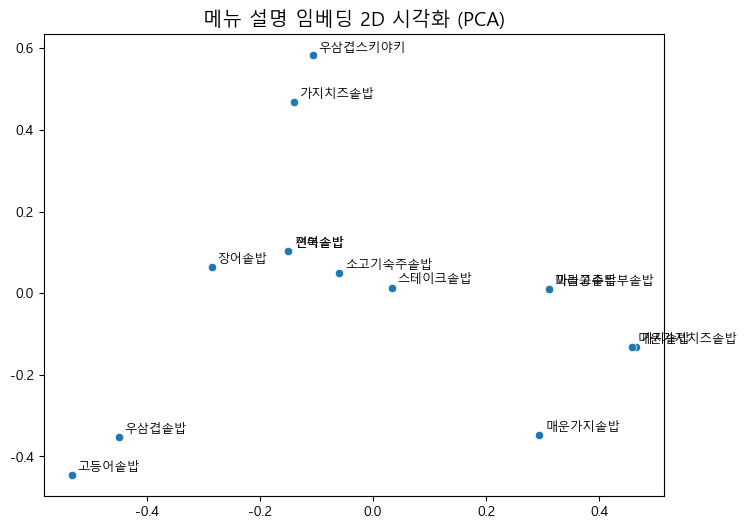

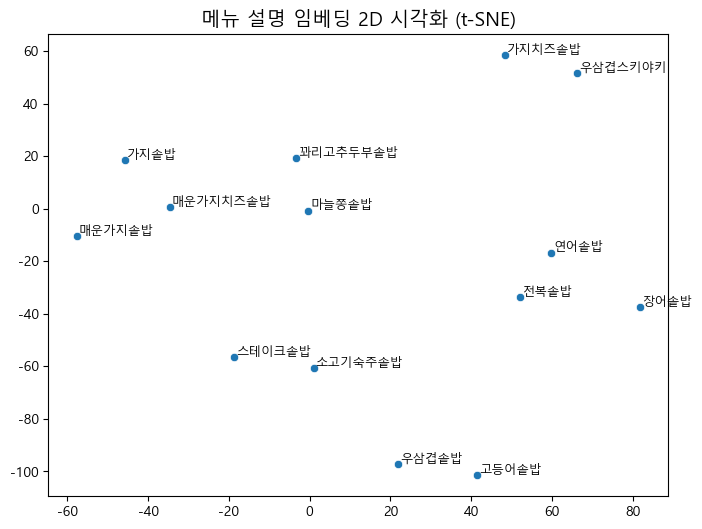

In [229]:
# 설명 텍스트
texts = merged["설명"].tolist()
menus = merged["상품명"].tolist()

# 1. TF-IDF 벡터화
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(texts)

# 2. 차원 축소 (t-SNE, PCA)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.toarray())

# t-SNE (조금 더 퍼짐)
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())

# 3. 시각화 - PCA
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1])
for i, menu in enumerate(menus):
    plt.text(X_pca[i,0]+0.01, X_pca[i,1]+0.01, menu, fontsize=9)
plt.title("메뉴 설명 임베딩 2D 시각화 (PCA)", fontsize=14)
plt.show()

# 4. 시각화 - t-SNE
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1])
for i, menu in enumerate(menus):
    plt.text(X_tsne[i,0]+0.5, X_tsne[i,1]+0.5, menu, fontsize=9)
plt.title("메뉴 설명 임베딩 2D 시각화 (t-SNE)", fontsize=14)
plt.show()

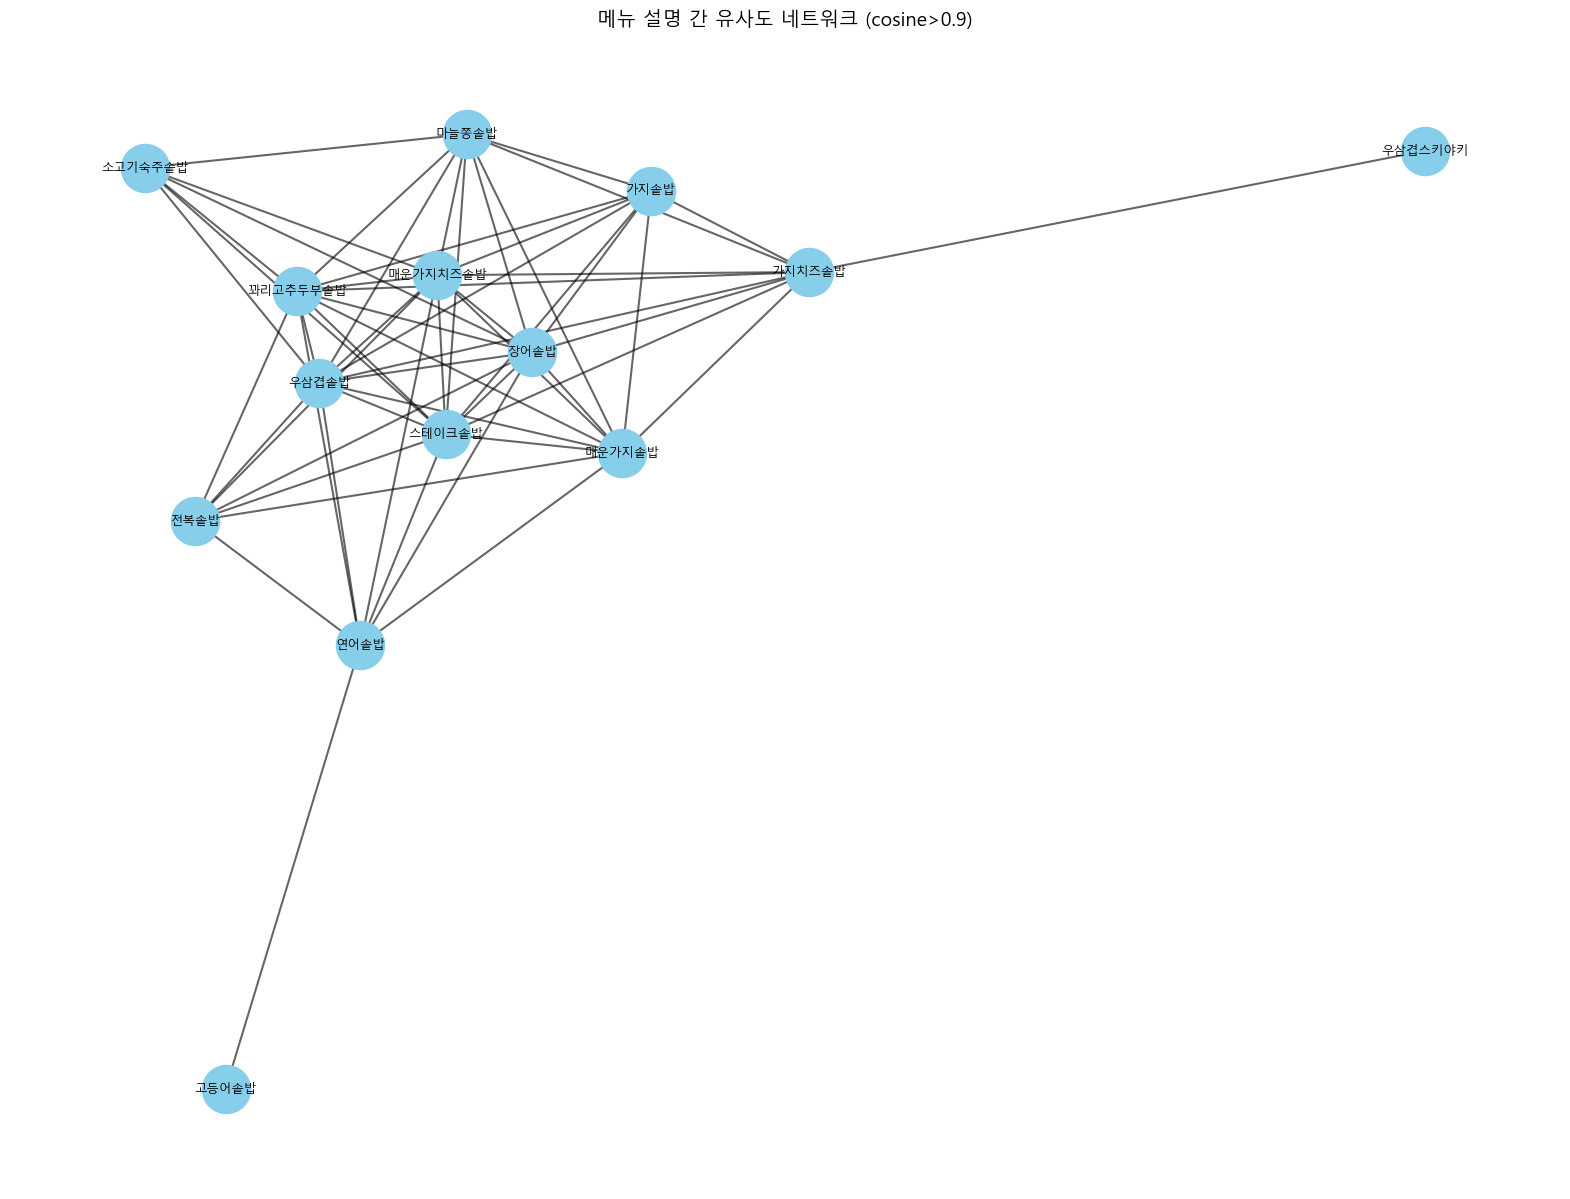

In [235]:
model = SentenceTransformer("snunlp/KR-SBERT-V40K-klueNLI-augSTS")

desc_embeddings = model.encode(merged["설명"].tolist(), convert_to_tensor=True)
sim_matrix = cosine_similarity(desc_embeddings.cpu().numpy())

# 유사도 행렬 → 네트워크 그래프 변환
G = nx.Graph()
for i, desc1 in enumerate(merged["설명"]):
    for j, desc2 in enumerate(merged["설명"]):
        if i < j and sim_matrix[i, j] > 0.90:
            G.add_edge(merged["상품명"].iloc[i], merged["상품명"].iloc[j], weight=sim_matrix[i, j])

# 시각화
plt.figure(figsize=(20,15))
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_nodes(G, pos, node_color="skyblue", node_size=1200)
nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.6)
nx.draw_networkx_labels(G, pos, font_family="Malgun Gothic", font_size=9)
plt.title("메뉴 설명 간 유사도 네트워크 (cosine>0.9)", fontsize=14)
plt.axis("off")
plt.show()

In [237]:
merged['설명'][1]

'가지치즈솥밥 | 평일피크=17 | 주말피크=12 | 피크동일여부=False | 클러스터=2 | 주말평일패턴=2 | 그룹=비인기'

In [238]:
# 한국어 지원 모델 로드 (예: KoSentenceBERT)
model = SentenceTransformer("snunlp/KR-SBERT-V40K-klueNLI-augSTS")

# 설명 컬럼 임베딩 (384차원 벡터)
embeddings = model.encode(merged["설명"].tolist(), convert_to_numpy=True)

# DataFrame에 추가
merged["상품명_임베딩"] = embeddings.tolist()

# 확인
print(merged[["상품명", "상품명_임베딩"]].head())

        상품명                                            상품명_임베딩
0      가지솥밥  [-0.7922078371047974, -0.8835394978523254, -0....
1    가지치즈솥밥  [-0.5013640522956848, -0.858461320400238, -0.7...
2     고등어솥밥  [-0.5658758282661438, -1.1022979021072388, -1....
3  꽈리고추두부솥밥  [-0.5987972021102905, -0.9359181523323059, -0....
4     마늘쫑솥밥  [-0.8530569672584534, -0.9186599254608154, -0....


In [239]:
merged

,상품명,평일 피크,주말 피크,피크 동일여부,클러스터,그룹,Top5_테이블,Top5_테이블_특성,설명,클러스터_주말평일패턴,상품명_임베딩
0,가지솥밥,12,13,False,1,"[시그니처, 인기, 채소]","[3, 5, 13, 2, 4]","[{'테이블코드': 3, '좌석유형': '4인석', '벽여부': '일반', '모서리...",가지솥밥 | 평일피크=12 | 주말피크=13 | 피크동일여부=False | 클러스터...,1,"[-0.7922078371047974, -0.8835394978523254, -0...."
1,가지치즈솥밥,17,12,False,2,[비인기],"[4, 5, 13, 14, 1]","[{'테이블코드': 4, '좌석유형': '4인석', '벽여부': '일반', '모서리...",가지치즈솥밥 | 평일피크=17 | 주말피크=12 | 피크동일여부=False | 클러...,2,"[-0.5013640522956848, -0.858461320400238, -0.7..."
2,고등어솥밥,19,18,False,2,"[생선, 신메뉴]","[5, 13, 3, 4, 1]","[{'테이블코드': 5, '좌석유형': '4인석', '벽여부': '벽', '모서리여...",고등어솥밥 | 평일피크=19 | 주말피크=18 | 피크동일여부=False | 클러스...,2,"[-0.5658758282661438, -1.1022979021072388, -1...."
3,꽈리고추두부솥밥,12,13,False,4,[채소],"[5, 3, 13, 4, 2]","[{'테이블코드': 5, '좌석유형': '4인석', '벽여부': '벽', '모서리여...",꽈리고추두부솥밥 | 평일피크=12 | 주말피크=13 | 피크동일여부=False | ...,4,"[-0.5987972021102905, -0.9359181523323059, -0...."
4,마늘쫑솥밥,12,13,False,5,[채소],"[13, 3, 5, 2, 15]","[{'테이블코드': 13, '좌석유형': '4인석', '벽여부': '벽', '모서리...",마늘쫑솥밥 | 평일피크=12 | 주말피크=13 | 피크동일여부=False | 클러스...,4,"[-0.8530569672584534, -0.9186599254608154, -0...."
5,매운가지솥밥,12,18,False,3,"[시그니처, 채소]","[5, 3, 13, 12, 4]","[{'테이블코드': 5, '좌석유형': '4인석', '벽여부': '벽', '모서리여...",매운가지솥밥 | 평일피크=12 | 주말피크=18 | 피크동일여부=False | 클러...,3,"[-0.706849217414856, -0.8516830801963806, -0.8..."
6,매운가지치즈솥밥,12,13,False,5,"[시그니처, 채소]","[5, 13, 3, 4, 15]","[{'테이블코드': 5, '좌석유형': '4인석', '벽여부': '벽', '모서리여...",매운가지치즈솥밥 | 평일피크=12 | 주말피크=13 | 피크동일여부=False | ...,4,"[-0.7876139879226685, -0.9539443254470825, -0...."
7,소고기숙주솥밥,12,13,False,5,[육류],"[5, 3, 13, 4, 15]","[{'테이블코드': 5, '좌석유형': '4인석', '벽여부': '벽', '모서리여...",소고기숙주솥밥 | 평일피크=12 | 주말피크=13 | 피크동일여부=False | 클...,4,"[-0.6970110535621643, -0.6025712490081787, -0...."
8,스테이크솥밥,12,13,False,1,"[인기, 육류]","[5, 13, 3, 4, 15]","[{'테이블코드': 5, '좌석유형': '4인석', '벽여부': '벽', '모서리여...",스테이크솥밥 | 평일피크=12 | 주말피크=13 | 피크동일여부=False | 클러...,1,"[-0.8750295042991638, -0.62489253282547, -0.92..."
9,연어솥밥,12,13,False,5,[생선],"[5, 13, 3, 12, 1]","[{'테이블코드': 5, '좌석유형': '4인석', '벽여부': '벽', '모서리여...",연어솥밥 | 평일피크=12 | 주말피크=13 | 피크동일여부=False | 클러스터...,4,"[-0.6804351210594177, -1.0477402210235596, -0...."


In [242]:
merged = merged[['상품명','상품명_임베딩']]

In [241]:
df = load_sheet_data(key_path, sheet_id, "요일")

In [243]:
df= df.merge(merged, on="상품명", how="left")

In [246]:
values = df.astype(str).values.tolist()

upload_to_sheet(
    key_path=key_path,
    sheet_id=sheet_id,
    sheet_name="상품명 임베딩",
    values=values
)